In [1]:
import gym

In [2]:
env = gym.make("CartPole-v1")

The four values are position, velocity, angle, angular velocity

In [3]:
env.reset()

array([ 0.02826596, -0.04967754, -0.00991669, -0.01205246], dtype=float32)

In [4]:
env.action_space

Discrete(2)

In [5]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)

# Policy Gradiant

We first make a basic policy which is to hit left if the rod is leaning left and vice versa

In [6]:
def basic_policy(obs): 
    angle = obs[2]
    return 0 if angle<0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0 
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action) 
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [7]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.162, 9.340650726796287, 24.0, 68.0)

In [8]:
all_obs=[]

obs = env.reset()
all_obs.append(obs)

for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    all_obs.append(obs)
    episode_rewards += reward
    if done:
        break
all_obs=np.stack(all_obs)

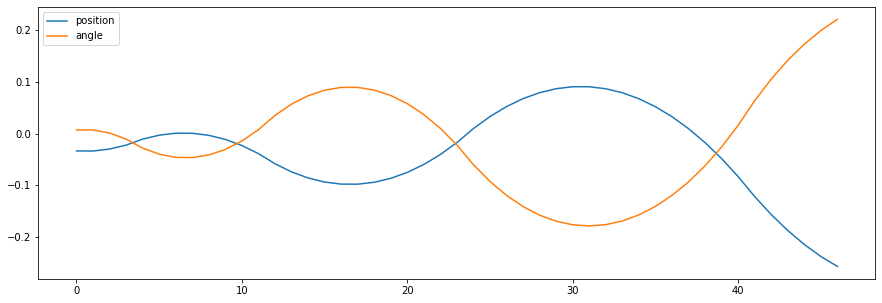

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15.0, 5.0]
plt.plot(all_obs[:,0],label='position')
plt.plot(all_obs[:,2],label='angle')
plt.legend()

In [11]:
from torch import nn
import torch

Now we make a DNN policy

In [12]:
class RLPolicy(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(4,5),
                      nn.ELU(),
                      nn.Linear(5,1),
                      nn.Sigmoid()
                     )
        
    def forward(self,x):
        if isinstance(x,np.ndarray):
            x=torch.tensor(x)
        return self.model(x)

This plays one step and returns the probability of going left. The action itself is chose to be 0 or 1 with that probability. The target has to be chosen carefully. The output of the model is for going left but we don't always go left. If we go right then from the models point of view we went opposite to it's recommendation so the target should be 0 and if we go left then from the models point of view we went along with it's recommendation so the target should be 1.

The loss is computed with this and the grads are computed and returned along with the env variables.

In [13]:
def play_one_step(env, obs, model, loss_fn):
    left_proba = model(obs[np.newaxis])
    action = torch.rand([1,1])>left_proba
    y_target = torch.tensor([[1.]]) - action.type(torch.float32)
    loss =loss_fn(left_proba,y_target)
    loss.backward()
    grads=[torch.clone(x.grad) for x in model.parameters()]
    [x.grad.data.zero_() for x in model.parameters()]
    obs, reward, done, info = env.step(int(action[0, 0].numpy())) 
    return obs, reward, done, grads
#play_one_step(env,obs,model,loss_fn)

In [14]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn): 
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = [] 
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn) 
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads) 
    return all_rewards, all_grads

In [15]:
def discount_rewards(rewards, discount_factor): 
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor 
    return discounted

In [16]:
def discount_and_normalize_rewards(all_rewards, discount_factor): 
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards] 
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [17]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [18]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [19]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [20]:
model=RLPolicy()

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [22]:
loss_fn=torch.nn.BCELoss()

In [23]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, 
                                                    n_episodes_per_update, 
                                                    n_max_steps,
                                                    model, 
                                                    loss_fn
                                                   )
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor
                                                      )
    for var_index,var in enumerate(model.parameters()):
        grads=[]
        for episode_index, final_rewards in enumerate(all_final_rewards):
            for step, final_reward in enumerate(final_rewards):
                grads.append(final_reward * all_grads[episode_index][step][var_index])
        mean_grads=torch.stack(grads,0).mean(0)
        var.grad.data=mean_grads
    optimizer.step()


In [24]:
all_obs=[]
obs = env.reset()
all_obs.append(obs)
for step in range(200):
    left_prob = model(obs)
    action = int(left_prob.detach().numpy()[0]<.5)
    obs, reward, done, info = env.step(action) 
    all_obs.append(obs)
    episode_rewards += reward
    if done:
        break
all_obs=np.stack(all_obs)

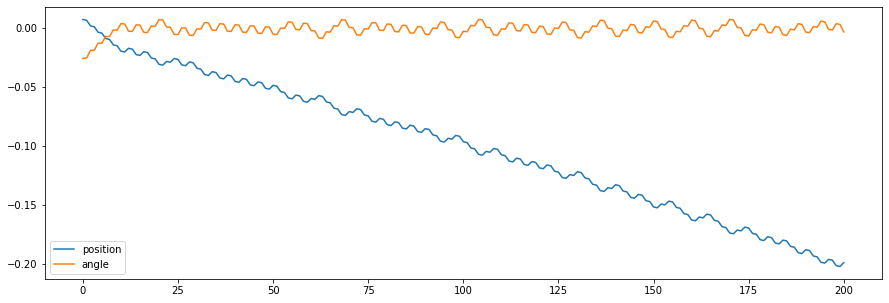

In [25]:
import matplotlib.pyplot as plt
plt.plot(all_obs[:,0],label='position')
plt.plot(all_obs[:,2],label='angle')
plt.plot
plt.legend()

In [26]:
totals = []
for episode in range(500):
    episode_rewards = 0 
    obs = env.reset()
    for step in range(200):
        left_prob = model(obs)
        obs, reward, done, info = env.step(int(left_prob.detach().numpy()[0]<.5)) 
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [27]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(200.0, 0.0, 200.0, 200.0)

# Markov Decision Process

In [28]:
transition_probabilities = [ # shape=[s, a, s']
[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
[None, [0.8, 0.1, 0.1], None]]

rewards = [ # shape=[s, a, s']
[[+10, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, -50]], [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [ [i for i,a in enumerate(s) if a] for s in transition_probabilities ]

In [29]:
possible_actions

[[0, 1, 2], [0, 2], [1]]

In [30]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions 
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

In [31]:
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [32]:
Q_vals_1=[]

In [33]:
gamma = 0.95 # the discount factor
for iteration in range(50): 
    Q_prev = Q_values.copy() 
    for s in range(3):
        for a in possible_actions[s]: 
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] 
                                     * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)
                                    ]
                                   )
    Q_vals_1.append(Q_values[0].copy())


In [34]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [35]:
Q_values.argmax(1)

array([0, 2, 1])

In [36]:
Q_vals_1=np.array(Q_vals_1)

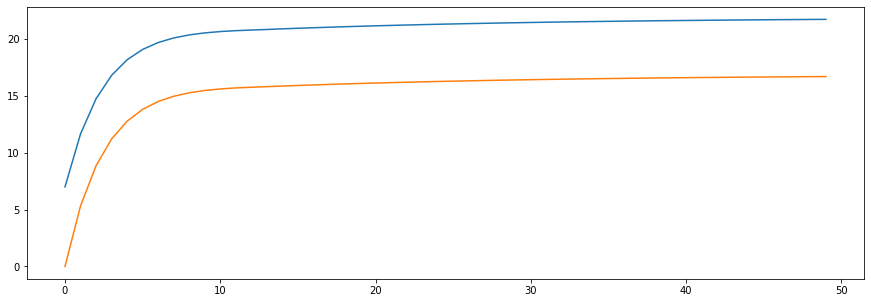

In [37]:
plt.plot(Q_vals_1[:,0])
plt.plot(Q_vals_1[:,2])

For Q-learning we do a simple example here

In [38]:
def step(state,action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2],p=probas)
    reward = rewards[state][action][next_state]
    return next_state,reward

In [39]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [40]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions 
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

In [41]:
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.95 # discount factor
state =0 # initial state

In [42]:
Qt_vals_1=[]

In [43]:
for iteration in range(100000):
    action = exploration_policy(state)
    next_state,reward  = step(state,action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0/(1+iteration*decay)
    Q_values[state,action] *= 1-alpha
    Q_values[state,action]  += alpha * (reward + gamma* next_value)
    state = next_state
    Qt_vals_1.append(Q_values[1].copy())


In [44]:
Q_values

array([[20.49641143, 19.40960142, 15.57212179],
       [ 0.        ,        -inf, -0.78999363],
       [       -inf, 52.58488887,        -inf]])

In [45]:
Q_values.argmax(1)

array([0, 0, 1])

In [46]:
Qt_vals_1=np.array(Qt_vals_1)

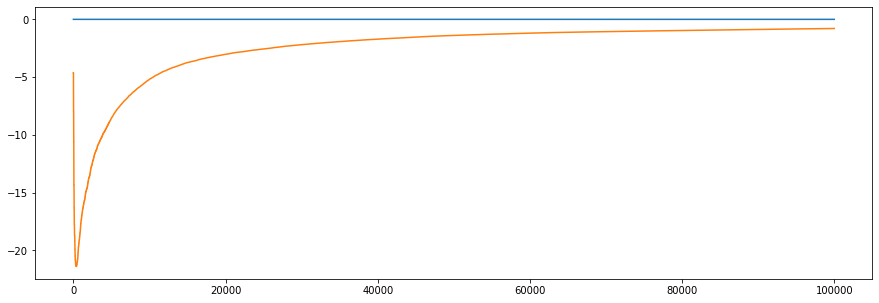

In [47]:
plt.plot(Qt_vals_1[20:,0])
plt.plot(Qt_vals_1[20:,2])

# Deep Q-Learning

In [48]:
env = gym.make("CartPole-v0")
input_shape = [4] # == env.observation_space.shape 
n_outputs = 2 

In [49]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(4,32),
            nn.ELU(),
            nn.Linear(32,32),
            nn.ELU(),
            nn.Linear(32,n_outputs)
        )
        
    def forward(self,x):
        if isinstance(x,np.ndarray):
            x=torch.tensor(x)
        return self.model(x)

In [50]:
model = Model()

In [51]:
state=np.random.uniform(0,1,4).astype(np.float32)
state

array([0.05472796, 0.6168405 , 0.04615219, 0.91786397], dtype=float32)

In [52]:
def epsilon_greedy_policy(state, epsilon=0): 
    if torch.rand(1) < epsilon:
        return torch.randint(2,(1,))[0]
    else:
        with torch.no_grad():
            Q_values = model(state[np.newaxis]) 
        return torch.argmax(Q_values[0])

In [53]:
from collections import deque 
replay_buffer = deque(maxlen=2000)


In [54]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
    dones = torch.tensor(dones).type(torch.int)
    rewards= torch.tensor(rewards).type(torch.float32)
    actions=torch.tensor(actions)
    return states, actions, rewards, next_states, dones

In [55]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon).numpy()
    next_state, reward, done, info = env.step(action) 
    replay_buffer.append((state, action, reward, next_state, done)) 
    return next_state, reward, done, info

In [56]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones =  experiences
    with torch.no_grad():
        next_Q_values = model(next_states)
    max_next_Q_values = torch.max(next_Q_values, axis=1).values
    target_Q_values = (rewards +
                           (1 - dones) * discount_factor * max_next_Q_values)
    mask = torch.nn.functional.one_hot(actions, n_outputs)
    all_Q_values = model(states)
    Q_values = torch.sum(all_Q_values*mask,1)
    loss =  loss_fn(Q_values,target_Q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [57]:
batch_size = 32
discount_factor = 0.95
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn=torch.nn.MSELoss()


In [58]:
total_rewards=[]
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    total_rewards.append(step+1)
    if episode > 50:
            training_step(batch_size)

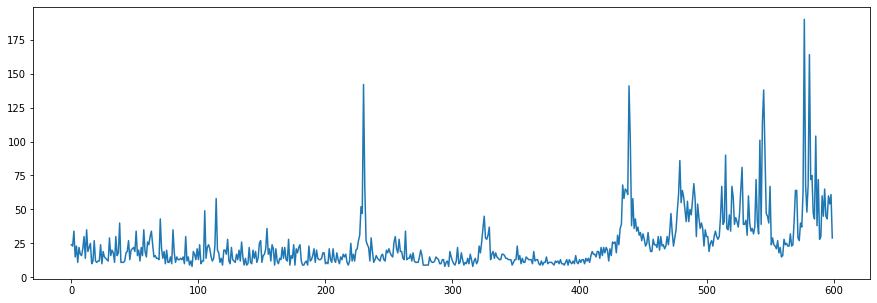

In [59]:
plt.plot(total_rewards)